# Predicting a Wine Rating

### The Data and Goal

<b>Source</b> - The data that I have worked on within this project comes from Kaggle. You can find the data if you follow below link: <br>https://www.kaggle.com/zynicide/wine-reviews

<b>Background</b> - The original idea behind the collection of the data was to find a way to predict what type of wine it is based on a description and review. I have in this project taken a different challenge and that is the one of predicting the wine rating based on the information we have about the specific wines in the dataset.

<b>Questions to answer</b>:
1. What are the top 5 countries with the best overall average wine rating
2. Is there a relationship between price and how good a wine is (rating)
3. Can we predict the rating based on the data we have about the different wines

### Contents - The Pipeline

1. Import libraries and packages for use throughout the pipeline
2. Check for and define the continous data variables
3. Check for and define the categorical data types
4. Investigate missing data and drop selected rows and column
5. For categorical variables - create dummy variables
6. Imputation
7. Split data into explanatory and response variables
8. Principal Component Analysis
9. Create training and test data sets
10. Train, Predict and Score
12. Conclusions
13. Discussion

### 1. Import libraries and packages for use throughout the pipeline. 

Below imports will be used and needed to handle the data within this pipeline. I have chose to seperate the imports for the different machine learning models and placed them lower down in the pipeline as I like having them close to the code for training. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#from helper_functions import do_pca, scree_plot, plot_components, pca_results
from sklearn.metrics import fbeta_score 
from sklearn.metrics import accuracy_score
import visuals as vs
import seaborn as sb
%matplotlib inline

In [3]:
df = pd.read_csv('winemag-data-130k-v2.csv', )
del df['Unnamed: 0']
df.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [4]:
df.shape

(129971, 13)

A first look at the data shows 14 different columns of data per row. One of the columns are just the index meaning 13 columns are actual usefull data. Each row is one review. In total we have 129.971 rows which equals the same amount of reviews. 

### 2. Check for and define the continous data variables

Second step is to find the continous data variables and look at the format and distribution of those values. 

In [5]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [6]:
df.describe().columns

Index(['points', 'price'], dtype='object')

In [7]:
len(df.describe().columns)

2

Distribution of continous values

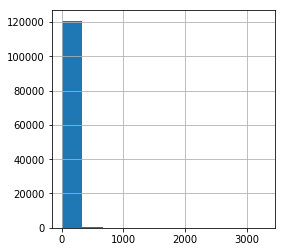

In [8]:
df['price'].hist(figsize=[4,4]);

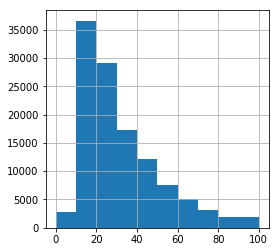

In [9]:
df['price'].hist(figsize=[4,4], range=[0,100]);

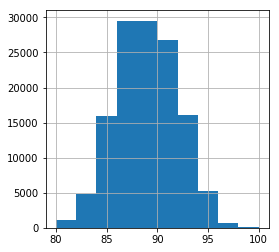

In [10]:
df['points'].hist(figsize=[4,4]);

In [11]:
df['price'].min() , df['price'].max()

(4.0, 3300.0)

Check correlation

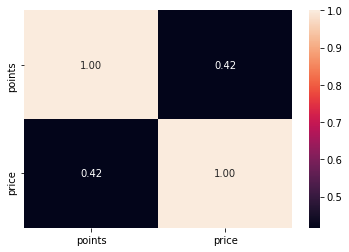

In [12]:
sb.heatmap(df.corr(), annot=True, fmt='.2f');

In [13]:
df.shape

(129971, 13)

In [14]:
df['points'].unique()

array([ 87,  86,  85,  88,  92,  91,  90,  89,  83,  82,  81,  80, 100,
        98,  97,  96,  95,  93,  94,  84,  99])

#### Conclusion 

We find 2 continous data variables in the dataset - price and points. The points data I would say follows the normal distribution and the price is right skewed with a minimum of 4 and a max of 3300. When running a heatmap for the correlation between the different values we see a correlation between price and points of 0.42.   

### 3. Check for and define the categorical data types

For the third step we look at what categorical data values are in the dataset. 

In [15]:
cat_cols = df.select_dtypes(include=['object']).columns

In [16]:
len(cat_cols)

11

In [17]:
df.select_dtypes(include=['object']).head(2)

,country,description,designation,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [18]:
cat_cols

Index(['country', 'description', 'designation', 'province', 'region_1',
       'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety',
       'winery'],
      dtype='object')

Categorical Columns: <br>
'country', 'description', 'designation', 'province', 'region_1',
'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety' and
'winery'

#### Conclusion

Since we only had two continous data types there is no suprise in the fact that there are 11 different columns with categorical values in the dataset. For these columns we need to take some transformation action to be able to add them into the model we later chose to predict the wine rating. This as the Machine Learning models only handles numeric data and does not take strings and objects as input values. 

### 4. Investigate missing data and drop selected rows and columns 

A big part of cleaning a dataset has to do with finding missing values and handling them in some way. This as we cannot add missing values into the training model later on only numeric data as mentioned before. 

In [19]:
df.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

We found many missing values. As an example we found almost 80.000 missing values in the region_2 column. 

In [20]:
df.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


As these are categorical values it is also interesting to see how many unique values there is in every column as this will decide on how many categories we will end up with when starting to create dummy variables (more on this in coming sections). 

In [21]:
for col in df.columns :
    uni_values = len(df[col].unique())
    name = col
    print(col,uni_values)

country 44
description 119955
designation 37980
points 21
price 391
province 426
region_1 1230
region_2 18
taster_name 20
taster_twitter_handle 16
title 118840
variety 708
winery 16757


Here comes a very important decision. We need to make a decision on which columns to remove and which to keep. I will start with taking away a vast amount of the columns in this dataset and try to focus on four of them to create the machine learning model on. The ones I will keep will be: <b>country, points, price and province.</b> Why? Well a couple of reasons. 
1. To keep all of the columns would create a dataset that is very large (after dummy variables) and I do not have the compute resources to run such a model. 
2. I believe this data could have a real impact on the amount of points the specific wine would get. 
3. Some data are clearly not relevant for the rating it got. Examples: taster_twitter_handle, taster_name and title.
4. The description data I am saving for another project where the goal would be to through a deep learning model find a way to predict the type of wine just be a description. 
5. Missing data - region 2 has 80.000 missing data values. Designation has almost 40.000 and region_1 has 26.000 missing values. If I would use these columns my dataset would be greatly reduced from its orignial state. 

This will be something you test your way forward on as if we dont not get the results we need with these values we can look at other ways to for the data. 

So I will drop the columns that are not of interest right now.

In [22]:
df_dropped = df.drop(columns=['description', 'region_1', 'region_2', 'taster_twitter_handle', 'title', 'designation','winery','taster_name','variety'])


After I dropped the columns I will have four columns left. <b>Country, points, price and province.</b>

In [23]:
df_dropped.head()

,country,points,price,province
0,Italy,87,NaN,Sicily & Sardinia
1,Portugal,87,15.0,Douro
2,US,87,14.0,Oregon
3,US,87,13.0,Michigan
4,US,87,65.0,Oregon


In [24]:
df_dropped.isnull().sum()

country       63
points         0
price       8996
province      63
dtype: int64

Price has almost 9.000 missing values. These needs to be dropped. I will also drop the 59 reviews that is missing the country and province data.

In [25]:
df_dropped = df_dropped.dropna(subset=['price'], axis=0)

In [26]:
df_dropped.isnull().sum()

country     59
points       0
price        0
province    59
dtype: int64

In [27]:
df_dropped = df_dropped.dropna(subset=['country'], axis=0)

In [28]:
df_dropped = df_dropped.dropna(subset=['province'], axis=0)

In [29]:
df_dropped.isnull().sum()

country     0
points      0
price       0
province    0
dtype: int64

After also removing the few missing values in country and price we have our dataset with no missing values and four columns. 

In [30]:
df_dropped.head()

,country,points,price,province
1,Portugal,87,15.0,Douro
2,US,87,14.0,Oregon
3,US,87,13.0,Michigan
4,US,87,65.0,Oregon
5,Spain,87,15.0,Northern Spain


I will make a copy of the dataframe now to save the state of the dataframe for further compute. 

In [31]:
df_clean = df_dropped.copy()

In [32]:
df_clean.head()

,country,points,price,province
1,Portugal,87,15.0,Douro
2,US,87,14.0,Oregon
3,US,87,13.0,Michigan
4,US,87,65.0,Oregon
5,Spain,87,15.0,Northern Spain


In [33]:
for col in df_clean.columns :
    uni_values = len(df[col].unique())
    name = col
    print(col,uni_values)

country 44
points 21
price 391
province 426


Unique values in each columns as above specified. This will be important to know when we start creating the dummy variables. 

#### Conclusion

We now have a dataset without missing values. The data that has been removed could be importat for the model but this is something we dont know at this moment. If we cant produce a model that is good with these values we will go back and evaluate if we should add some more features to the dataset. 

### 5. For categorical variables - create dummy variables

When having categorical values in our dataset we need to convert them into numeric values somehow for the machine learning model to work. Here we can use a function called get_dummies on the dataset to make this happen. What the function does is to make a new column for each unique category in the original column and give it a value of 1 if it has that value and a 0 if it does not. In our newly cleaned dataset we have two columns that has categorical data. Country and Province.

In [34]:
cat_cols = df_clean.select_dtypes(include=['object']).columns

In [35]:
cat_cols

Index(['country', 'province'], dtype='object')

In [36]:
for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df_clean = pd.concat([df_clean.drop(col, axis=1), pd.get_dummies(df_clean[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)
        except:
            continue

In [37]:
df_clean.shape

(120916, 466)

After performing the function on the dataset we now have a new dataset with 120916 rows and 466 columns. Quite a few more columns then the previous four. 

In [38]:
df_clean.head(1)

,points,price,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,...,province_Western Australia,province_Western Cape,province_Wiener Gemischter Satz,province_Württemberg,province_Zenata,province_Österreichischer Perlwein,province_Österreichischer Sekt,province_Štajerska,province_Župa,province_nan
1,87,15.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Imputation

Step six would be to impute values into the dataset if needed. In our case we now have a dataset with no missing values so this step will be skipped in this project. 

### 7. Split data into explanatory and response variables

This step will just focus on dividing the dataset into two new dataframes. One for the explanatory data (=the data that we want to use to create the ML model to in the end predict the points for each wine) and one for the response data (=in this case the rating for each wine). 

In [39]:
response_col = 'points'

In [40]:
#Split into explanatory and response variables
X = df_clean.drop(response_col, axis=1)
y = df_clean[response_col]

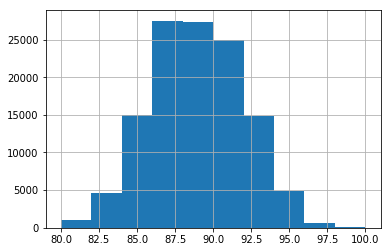

In [41]:
y.hist()

In [42]:
X.head()

,price,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,...,province_Western Australia,province_Western Cape,province_Wiener Gemischter Satz,province_Württemberg,province_Zenata,province_Österreichischer Perlwein,province_Österreichischer Sekt,province_Štajerska,province_Župa,province_nan
1,15.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,15.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
y.head()

1    87
2    87
3    87
4    87
5    87
Name: points, dtype: int64

### 8. Principal Component Analysis & Normalizing

As we have a lot of columns in our dataset (=466) I want to look at doing some feature engineering and by using Principal Component Analysis reduce the amount of features. This will reduce both the computational power needed, reduce training time and possibly also make the model perform better. 

But what is PCA? Well PCA creates new features (= components) from the original data. These components are linear representation of the data and will try to capture as much of the variance as possible to in the end represent the original data as good as possible. 

Lets create a function to create these new components as well as using StandardScaler to normalize the data.

In [44]:
def create_pca(n_components, full_data) :
    X = StandardScaler().fit_transform(full_data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

We start by creating 200 components. Which still is a lot but also more than half of the inital features we have. 

In [45]:
pca, X_pca = create_pca(200, df_clean)

Lets also create a function to visualize the variance we cover with these new components and features. This type of plot is called a scree plot. 

In [46]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize = (10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

(0.5284000000000001, None)

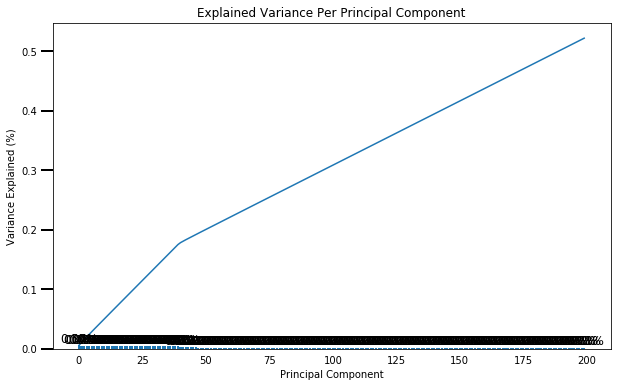

In [47]:
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns = df_clean.keys())
components.index = dimensions
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions
variance_ratios['Explained Variance'].sum(), scree_plot(pca)

#### Normilize the data (if not using PCA)

If we are not using the PCA components we created above we will need to normalize the data we have before performing the modeling.

In [48]:
X_standard = StandardScaler().fit_transform(X)

In [49]:
X_standard = pd.DataFrame(X_standard, index=X.index, columns=X.columns)

In [50]:
X_standard.head()

,price,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,...,province_Western Australia,province_Western Cape,province_Wiener Gemischter Satz,province_Württemberg,province_Zenata,province_Österreichischer Perlwein,province_Österreichischer Sekt,province_Štajerska,province_Župa,province_nan
1,-0.496422,-0.004067,-0.139064,-0.153938,-0.004067,-0.019719,-0.034168,-0.045881,-0.194694,-0.002876,...,-0.048606,-0.047744,-0.01438,-0.01349,-0.012536,-0.005752,-0.022466,-0.01349,-0.008134,0.0
2,-0.520794,-0.004067,-0.139064,-0.153938,-0.004067,-0.019719,-0.034168,-0.045881,-0.194694,-0.002876,...,-0.048606,-0.047744,-0.01438,-0.01349,-0.012536,-0.005752,-0.022466,-0.01349,-0.008134,0.0
3,-0.545166,-0.004067,-0.139064,-0.153938,-0.004067,-0.019719,-0.034168,-0.045881,-0.194694,-0.002876,...,-0.048606,-0.047744,-0.01438,-0.01349,-0.012536,-0.005752,-0.022466,-0.01349,-0.008134,0.0
4,0.722172,-0.004067,-0.139064,-0.153938,-0.004067,-0.019719,-0.034168,-0.045881,-0.194694,-0.002876,...,-0.048606,-0.047744,-0.01438,-0.01349,-0.012536,-0.005752,-0.022466,-0.01349,-0.008134,0.0
5,-0.496422,-0.004067,-0.139064,-0.153938,-0.004067,-0.019719,-0.034168,-0.045881,-0.194694,-0.002876,...,-0.048606,-0.047744,-0.01438,-0.01349,-0.012536,-0.005752,-0.022466,-0.01349,-0.008134,0.0


#### Conclusion

Using PCA we can create new features that will explain about 50% of the variance in the dataset. We will try this approach below and see if we get good results. Otherwise we have now normalized the data and it is ready to be modeled around.

### 9. Create training and test data sets

Splitting data in train, test for both explanatory and response values. First for the PCA data and then the original normalized data. 

In [51]:
#Split into train and test - PCA data
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_pca, y, test_size=0.3, random_state=9)


In [52]:
#Split into train and test - Normalized data
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.3, random_state=9)


### 10. Instantiate a Learning models, Predict and Score 

To predict the ratings(points) I will try 4 different machine learning models. I will also measure the accuracy of the different models to compare them against each other and in the end pick the one that performs the best. 
1. Linear Regression 
2. Logistic Regression
3. Decision Tree - Random Forest
4. SVM - Support Vector Machine
5. Naive Bayes - Gaussian

In [53]:
# Import the four supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [54]:
# Scoring imports
from sklearn.metrics import fbeta_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [65]:
def evaluation_model(X_train, y_train, X_test, y_test, type_model, model) :
    # model selection
    if type_model == 'linear' :
        model = LinearRegression()
    elif type_model == 'classification' :       
        if model == 'log':
            model = LogisticRegression()
        elif model == 'random':
            model = RandomForestClassifier()
        elif model == 'SVM':
            model = SVC()
        elif model == 'GNB':
            model = GaussianNB()
        else :
            print('You did not pick a model.... please try again..')
    else : 
        print('You did not pick a model type.... please try again..')
    
    # fit model
    model = model.fit(X_train, y_train)

    # predictions
    pred_train = model.predict(X_train[:300])
    pred_test = model.predict(X_test)
    
    # evaluation metrics - linear
    
    if type_model == 'linear' :
        
        # mean absolute error
        mae_results_train = mean_absolute_error(y_train[:300], pred_train)
        mae_results_test = mean_absolute_error(y_test, pred_test)
        
        # mean squared error
        mse_results_train = mean_squared_error(y_train[:300], pred_train)
        mse_results_test = mean_squared_error(y_test, pred_test)
        
        # r2score
        r2score_results_train = r2_score(y_train[:300], pred_train)
        r2score_results_test = r2_score(y_test, pred_test)
        
        print('Mean Absolute Error - training results:')
        print(mae_results_train)
        print('-----------------------')
        print('Mean Absolute Error - test results:')
        print(mae_results_test)
        print('-----------------------')
        
        print('Mean Squared Error - training results:')
        print(mse_results_train)
        print('-----------------------')
        print('Mean Squared Error - test results:')
        print(mse_results_test)
        print('-----------------------')
        
        print('r2score training results:')
        print(r2score_results_train)
        print('-----------------------')
        print('r2score test results:')
        print(r2score_results_test)
        print('-----------------------')
    
    # evaluation metrics - classification
    
    else :

        #fbeta score
        fbeta_trainning_results = fbeta_score(y_train[:300], pred_train, 0.5, average='weighted')
        fbeta_test_results = fbeta_score(y_test, pred_test, 0.5, average='weighted')

        #accuracy_score
        acc_training_results = accuracy_score(y_train[:300], pred_train)
        acc_test_results = accuracy_score(y_test, pred_test)

        print('fbeta training results:')
        print(fbeta_trainning_results)
        print('-----------------------')
        print('fbeta test results:')
        print(fbeta_test_results)
        print('-----------------------')
        print('accuracy training results:')
        print(acc_training_results)
        print('-----------------------')
        print('accuracy test results:')
        print(acc_test_results)

#### Classification models

Random Forest

In [66]:
evaluation_model(X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, 'classification', 'random')

fbeta training results:
1.0
-----------------------
fbeta test results:
0.9775093962395736
-----------------------
accuracy training results:
1.0
-----------------------
accuracy test results:
0.9776981392143349


In [67]:
evaluation_model(X_train, y_train, X_test, y_test, 'classification', 'random')

fbeta training results:
0.2943794314924068
-----------------------
fbeta test results:
0.17893016230711004
-----------------------
accuracy training results:
0.26666666666666666
-----------------------
accuracy test results:
0.18776016540317023


/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Regression

In [61]:
evaluation_model(X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, 'classification' ,'log')

fbeta training results:
0.24333333333333337
-----------------------
fbeta test results:
0.2743487250172295
-----------------------
accuracy training results:
0.24333333333333335
-----------------------
accuracy test results:
0.2743487250172295


/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [64]:
evaluation_model(X_train, y_train, X_test, y_test,'classification','log')

fbeta training results:
0.17333333333333334
-----------------------
fbeta test results:
0.16986905582356995
-----------------------
accuracy training results:
0.17333333333333334
-----------------------
accuracy test results:
0.16986905582356995


Gaussian NB

In [62]:
evaluation_model(X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, 'classification', 'GNB')

fbeta training results:
0.013333333333333334
-----------------------
fbeta test results:
0.009235010337698139
-----------------------
accuracy training results:
0.013333333333333334
-----------------------
accuracy test results:
0.009235010337698139


In [63]:
evaluation_model(X_train, y_train, X_test, y_test, 'classification', 'GNB')

fbeta training results:
0.006666666666666667
-----------------------
fbeta test results:
0.005403170227429358
-----------------------
accuracy training results:
0.006666666666666667
-----------------------
accuracy test results:
0.005403170227429359


Support Vector Machine

In [ ]:
evaluation_model(X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, 'classification', 'SVM')

In [ ]:
evaluation_model(X_train, y_train, X_test, y_test, 'classification', 'SVM')

#### Linear Models

Linear Regression

In [59]:
evaluation_model(X_train_PCA, y_train_PCA, X_test_PCA, y_test_PCA, 'linear', 'linear')

Mean Absolute training results:
1.5174869945734868
-----------------------
Mean Absolute test results:
1.4429873839161402
-----------------------
Mean Squared training results:
4.589096075031801
-----------------------
Mean Squared test results:
3.608067934087226
-----------------------
r2score training results:
0.5319605020229476
-----------------------
r2score test results:
0.6150267313417386
-----------------------


In [68]:
evaluation_model(X_train, y_train, X_test, y_test, 'linear', 'linear')

Mean Absolute Error - training results:
2.2323388671875
-----------------------
Mean Absolute Error - test results:
1801844756896.5098
-----------------------
Mean Squared Error - training results:
8.573716569741567
-----------------------
Mean Squared Error - test results:
1.1355337281299952e+28
-----------------------
r2score training results:
0.12557115094358295
-----------------------
r2score test results:
-1.2115906323712189e+27
-----------------------


### 11. Conclusions

* Clearly the Randomforest model is the best choice here with a accuracy of 0.977 and fbeta score of 0.977 on the test data. Notable here is the fact that these results came using the PCA derived featues (200 of them) and not using the normalized original data. 
<br><br>
* All models performed better with the PCA engineered features.
<br><br>
* The linear model did not do that bad with a r2 score of 0.61 on the test data. 
<br><br>
* The worst model was the Gaussian Navie Bias model with very low results. 
<br><br>
* I shut down the SVM model training as it took too long to compute. This was not to bad as we already got a very good score for the Random Forest.